In [3]:
!pip install evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 2.6 MB/s eta 0:00:00


In [4]:
from transformers import AutoTokenizer, AutoModelForCausalLM, set_seed
from datasets import load_dataset
import evaluate
import pandas as pd
import torch
torch.manual_seed(42)
torch.cuda.manual_seed_all(42)
set_seed(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

class InferenceModel:
    def __init__(self, model_name, device):
        self.model_name = model_name
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        self.model = AutoModelForCausalLM.from_pretrained(model_name, device_map="auto", offload_buffers=True)
        self.acc_metric = evaluate.load("accuracy")  
        self.precision_metric = evaluate.load("precision")  
        self.recall_metric = evaluate.load("recall") 
        
        self.df = pd.DataFrame(columns=['pred_answer', 'pred_answertext'])
        self.predictions = []
        self.references = []
        self.answers = []
        self.eval_results = []
        self.model.eval()
        self.logits = []
    def init_eval(self):
        self.acc_metric = evaluate.load("accuracy")  
        self.precision_metric = evaluate.load("precision")  
        self.recall_metric = evaluate.load("recall") 
        self.df = pd.DataFrame(columns=['pred_answer', 'pred_answertext'])
        self.predictions = []
        self.references = []
        self.answers = []
        self.eval_results = []
        
    def get_logprobs(self, prompt):
        inputs = self.tokenizer(prompt, return_tensors="pt")
        outputs = self.model(**inputs, output_hidden_states=True)
        logits = outputs.logits
        # Shape remains, but values are now normalized as log probabilities over the vocabulary.
        logprobs = torch.gather(F.log_softmax(logits, dim=2), 2, output_ids.unsqueeze(2))
        return logprobs, outputs
        
    def inference(self, prompt, max_new_tokens=1):
        """
        Performs inference on a given prompt.
        Returns the decodede output
        """
        generated_text = ''
        len_sentence = 0
        if self.model_name == 'Qwen/Qwen2.5-0.5B-Instruct':
            # WARNING: messages ini harus sama dengan messages di check_index_prompt
            messages = [
            {"role": "system", "content": "You are Qwen, created by Alibaba Cloud. You are a helpful assistant."},
            {"role": "user", "content": prompt}
            ]
            text = self.tokenizer.apply_chat_template(
                messages,
                tokenize=False,
                add_generation_prompt=True
            )
            model_inputs = self.tokenizer([text], return_tensors="pt").to(self.model.device)
            
            generated_ids = self.model.generate(
                    **model_inputs,
                    do_sample=False,
                    temperature=None,
                    top_p=None,
                    top_k=None,
                    max_new_tokens=max_new_tokens
                )
            generated_ids = [
                output_ids[len(input_ids):] for input_ids, output_ids in zip(model_inputs.input_ids, generated_ids)
            ]
            generated_text = self.tokenizer.batch_decode(generated_ids, skip_special_tokens=True)[0]
            len_sentence = len(self.tokenizer(text, return_offsets_mapping=True, add_special_tokens=False)["input_ids"])
        elif self.model_name == "google/gemma-2-2b-it":
            # WARNING: messages ini harus sama dengan messages di check_index_prompt
            messages = [
            {"role": "user", "content": prompt}
            ]
            text = self.tokenizer.apply_chat_template(
                messages,
                tokenize=False,
                add_generation_prompt=True
            )
            model_inputs = self.tokenizer([text], return_tensors="pt", add_special_tokens=False).to(self.model.device)
            # print(f"(model_inputs['input_ids'] {(model_inputs['input_ids'])}")
            
            # print(f"len(model_inputs['input_ids'] {len(model_inputs['input_ids'])}")
            sentence_token_texts = self.tokenizer.convert_ids_to_tokens((model_inputs['input_ids'])[0])
            # print(f"sentence_token_texts {sentence_token_texts}")
            
            
            generated_ids = self.model.generate(
                    **model_inputs,
                    do_sample=False,
                    temperature=None,
                    top_p=None,
                    top_k=None,
                    max_new_tokens=max_new_tokens
                )
            generated_ids = [
                output_ids[len(input_ids):] for input_ids, output_ids in zip(model_inputs.input_ids, generated_ids)
            ]
            generated_text = self.tokenizer.batch_decode(generated_ids, skip_special_tokens=True)[0]
            len_sentence = len(self.tokenizer(text, return_offsets_mapping=True, add_special_tokens=False)["input_ids"])
            # print()
            
        else:
            inputs = self.tokenizer(prompt, return_tensors="pt").to(self.model.device)
            len_sentence = len(inputs["input_ids"])
            output = self.model.generate(
                **inputs, 
                do_sample=False,
                temperature=None,
                top_p=None,
                top_k=None,
                max_new_tokens=1)
            # print(f"output: {output}")
            generated_ids = [
                output_ids[len(input_ids):] for input_ids, output_ids in zip(inputs.input_ids, output)
            ]
            generated_text = self.tokenizer.batch_decode(generated_ids, skip_special_tokens=True)[0]

        
        self.answers.append(generated_text)
        # answer = "1" if "option1" in generated_text else "2" if "option2" in generated_text else None
        
        return generated_text, len_sentence

    def batch_inference(self, prompts):
        """
        Perform batch inference.
        """
        inputs = self.tokenizer(prompts, return_tensors="pt", padding=True, truncation=True).to(self.model.device)
        outputs = self.model.generate(**inputs, max_new_tokens=50)
        generated_texts = []
        for input_ids, output_ids in zip(inputs.input_ids, outputs):
            generated_ids = [
                output_ids[len(input_ids):]
            ]
            generated_text = self.tokenizer.batch_decode(generated_ids, skip_special_tokens=True)[0]
            generated_texts.append(generated_text)
        self.answers.extend(generated_texts)
        return generated_texts

    def eval(self):
        """
        Evaluates the predictions against the references 
        """
        accuracy_results = self.acc_metric.compute(predictions=self.predictions, references=self.references)

        precision_results = self.precision_metric.compute(predictions=self.predictions, references=self.references, average="macro")

        recall_results = self.recall_metric.compute(predictions=self.predictions, references=self.references, average="macro")

        results = {
            'acc' : accuracy_results,
            'prec' : precision_results,
            'recall' : recall_results
        }
        self.eval_results.append(results)
        print("Evaluation Results:\n", results)
        return results

    
    def parse_save_output(self, generated_text, unique_labels, current_labeltexts, currentlabel):
        """
        generated_text: output from model.generate (e.g. '1', 'option 1', 'anna')
        unique_labels: unique labels from dataset (list of string e.g. ["1", "2"])
        current_labeltexts: the current label options (dict of current label text e.g. {1:'anna', 2:'susan'})
        currentlabel = the current reference label from dataset (string, the dataset['answer']. e.g. "2", "1" )
        """
        pred = None
        clean_generated_text = generated_text.lower().strip()
        for i in unique_labels:
            if str(i) in clean_generated_text or current_labeltexts[int(i)].lower().strip() in clean_generated_text or current_labeltexts[int(i)].lower().removeprefix("the").strip() in clean_generated_text :
                pred = i
                break
        # print(f"gt: {generated_text}")
        # print(f"pred : {pred}")
        if pred == None:
            pred = "9"
        self.predictions.append(pred)
        self.references.append(currentlabel)
        ans_dict = ({'pred_answer':pred, 'pred_answertext' : generated_text})
        # print(f"ans_dict {ans_dict}")
        self.df.loc[len(self.df)] = ans_dict
        return pred



In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
massive_qwen = InferenceModel("Qwen/Qwen2.5-0.5B-Instruct", device)

tokenizer_config.json:   0%|          | 0.00/7.30k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/2.78M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/1.67M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/7.03M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/659 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/988M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/242 [00:00<?, ?B/s]

# LAPE

In [7]:
def LAPE(activation_probs, top_rate = 0.01,filter_rate=0.95,activation_bar_ratio=0.95):
    """    
    activation_probs = # layer x inter x lang_num
    """    
    num_layers = activation_probs.size(0)
    normed_activation_probs = activation_probs / activation_probs.sum(dim=-1, keepdim=True)
    normed_activation_probs[torch.isnan(normed_activation_probs)] = 0
    log_probs = torch.where(normed_activation_probs > 0, normed_activation_probs.log(), 0)
    entropy = -torch.sum(normed_activation_probs * log_probs, dim=-1)
    largest = False
    
    if torch.isnan(entropy).sum():
        print(torch.isnan(entropy).sum())
        raise ValueError
    
    flattened_probs = activation_probs.flatten()
    top_prob_value = flattened_probs.kthvalue(round(len(flattened_probs) * filter_rate)).values.item()
    print(top_prob_value)
    # dismiss the neruon if no language has an activation value over top 90%
    top_position = (activation_probs > top_prob_value).sum(dim=-1)
    entropy[top_position == 0] = -torch.inf if largest else torch.inf

    flattened_entropy = entropy.flatten()
    top_entropy_value = round(len(flattened_entropy) * top_rate)
    _, index = flattened_entropy.topk(top_entropy_value, largest=largest)
    row_index = index // entropy.size(1)
    col_index = index % entropy.size(1)
    selected_probs = activation_probs[row_index, col_index] # n x lang
    # for r, c in zip(row_index, col_index):
    #     print(r, c, activation_probs[r][c])

    # print(selected_probs.size(0), torch.bincount(selected_probs.argmax(dim=-1)))
    selected_probs = selected_probs.transpose(0, 1)
    activation_bar = flattened_probs.kthvalue(round(len(flattened_probs) * activation_bar_ratio)).values.item()
    # print((selected_probs > activation_bar).sum(dim=1).tolist())
    lang, indice = torch.where(selected_probs > activation_bar)

    merged_index = torch.stack((row_index, col_index), dim=-1)
    final_indice = []
    for _, index in enumerate(indice.split(torch.bincount(lang).tolist())):
        lang_index = [tuple(row.tolist()) for row in merged_index[index]]
        lang_index.sort()
        layer_index = [[] for _ in range(num_layers)]
        for l, h in lang_index:
            layer_index[l].append(h)
        for l, h in enumerate(layer_index):
            layer_index[l] = torch.tensor(h).long()
        final_indice.append(layer_index)
    return final_indice

In [8]:
def get_prob_for_lape(tensor, num_lang, num_layer, num_neurons):
    """
    num_neurons: intermediate layer (neurons in a layer)
    """
    full_languages_raw_values = (tensor.transpose(0,1)[0] > 0).half()
    probs = full_languages_raw_values.mean(dim=-2)
    probs.shape
    del full_languages_raw_values
    probs = probs.reshape(num_lang,num_layer,num_neurons)
    transposed_probs = probs.transpose(0,1).transpose(-1,-2)
    transposed_probs.shape
    return transposed_probs

def convert_to_global_indices(final_indice, intermediate_size):
    final_flattened = []
    
    for lang_idx, layers in enumerate(final_indice):  # Iterate over languages
        global_indices = []
        for layer_idx, hidden_units in enumerate(layers):  # Iterate over layers
            if hidden_units.numel() > 0:  # If there are selected neurons
                global_indices.extend((layer_idx * intermediate_size + hidden_units).tolist())
        
        final_flattened.append((global_indices))  
    
    return final_flattened



In [9]:
import numpy as np
from scipy.stats import entropy
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


def get_k_lang_actv_dict(k, full_neurons, method="default", topk=0):
    
    """
    di sini anggap activated neuron (avg token) yang di setiap row di dataset(cuman 2 row) actv valuenya > 0.
    k = num language"""
    activation_dict = {}
    
    full_neurons = full_neurons.transpose(-3,-4)[0].transpose(-1,-2)

    if method == "default":
        for i in range (full_neurons.size(0)):
            tensor_lang = full_neurons[i]
            rows_with_both_positive = (tensor_lang > 0).all(dim=-1)
            
            indices = torch.where(rows_with_both_positive)[0]
            activation_dict[i] = indices
            # indices.shape
            # print(indices.shape)
    elif method == "topk":
        if topk==0:
            print(f"topk must not be 0")
        top = (full_neurons.mean(dim=-1).topk(topk).indices)
        for i in range (full_neurons.size(0)):
            activation_dict[i] = top[i]
    
    return activation_dict

# Step 1: Convert lists to probability distributions
def to_probability_distribution(values):
    total = sum(values)
    return [v / total for v in values]


def make_heatmap_neuron_overlap(activation_dict, k, with_label=True, method="default", alpha=1, normalized =False):    
    # Example dictionary: keys 0-52, values are 1D tensors of activated neuron indices
    # activation_dict = get_k_lang_actv_dict(10)

    overlap_matrix = torch.tensor([])
    if method == "default":
        # Step 1: Create a binary matrix
        max_neuron_index = max(max(indices) for indices in activation_dict.values()) + 1  # Find the maximum neuron index
        binary_matrix = torch.zeros((k+1, max_neuron_index), dtype=torch.int)  # Initialize binary matrix
        
        for key, indices in activation_dict.items():
            binary_matrix[key, indices] = 1  # Set activated neurons to 1
        
        # Step 2: Compute overlaps (dot product between rows)
        overlap_matrix = torch.matmul(binary_matrix, binary_matrix.T)  # Dot product of binary_matrix with its transpose

    elif method == "jaccard":
        max_neuron_index = max(max(indices) for indices in activation_dict.values()) + 1
        binary_matrix = torch.zeros((k+1, max_neuron_index), dtype=torch.int)
    
        # Fill binary matrix with activation data
        for key, indices in activation_dict.items():
            binary_matrix[key, indices] = 1  
    
        # Compute Jaccard distance matrix
        overlap_matrix = torch.zeros((k+1, k+1))
    
        for i in range(k+1):
            for j in range(k+1):
                intersection = (binary_matrix[i] & binary_matrix[j]).sum().item()
                union = (binary_matrix[i] | binary_matrix[j]).sum().item()
                jaccard_similarity = intersection / union if union > 0 else 0
                overlap_matrix[i, j] = jaccard_similarity
        overlap_matrix = overlap_matrix ** alpha
        if normalized:
            overlap_matrix = overlap_matrix / overlap_matrix.sum(axis=1, keepdims=True)

    
    # Step 3: Visualize the heatmap
    plt.figure(figsize=(10, 8))
    if with_label:
        sns.heatmap(overlap_matrix.numpy(), annot=True, fmt="d", cmap="YlOrRd", 
                    xticklabels=range(k+1), yticklabels=range(k+1))
    else:
        sns.heatmap(overlap_matrix.numpy(), fmt="d", cmap="YlOrRd",cbar=True)
    plt.xlabel("Key")
    plt.ylabel("Key")
    plt.title(f"Overlap Heatmap of Activated Neurons: {method}")
    plt.show()
    return overlap_matrix


def normed_heatmap_neuron_overlap(num_lang, activation_dict):
    # Step 1: Create a binary matrix
    max_neuron_index = max(max(indices) for indices in activation_dict.values()) + 1  # Find the maximum neuron index
    binary_matrix = torch.zeros((num_lang, max_neuron_index), dtype=torch.int)  # Initialize binary matrix
    
    for key, indices in activation_dict.items():
        binary_matrix[key, indices] = 1  # Set activated neurons to 1
    
    # Step 2: Compute overlaps (dot product between rows)
    overlap_matrix = torch.matmul(binary_matrix, binary_matrix.T)  # Dot product of binary_matrix with its transpose
    
    # Step 3: Normalize the overlap matrix
    # Compute the number of activated neurons for each key
    num_activated_neurons = binary_matrix.sum(dim=1, keepdim=True)
    
    # Normalize by the minimum number of activated neurons between each pair of keys
    normalized_overlap_matrix = overlap_matrix / torch.minimum(
        num_activated_neurons, num_activated_neurons.T
    )
    
    # Ensure the diagonal is exactly 1 (self-overlap is always 1)
    normalized_overlap_matrix.fill_diagonal_(1)
    
    # Step 4: Visualize the normalized heatmap (no labels or annotations)
    plt.figure(figsize=(10, 8))
    sns.heatmap(normalized_overlap_matrix.numpy(), cmap="YlOrRd", cbar=True, vmin=0, vmax=1)
    plt.xlabel("Key")
    plt.ylabel("Key")
    plt.title("Normalized Overlap Heatmap of Activated Neurons")
    plt.show()

In [10]:

def visualize_lape(full_languages_raw_values, num_layer, top_rate = 0.05,filter_rate=0.80,activation_bar_ratio=0.80): 
    num_lang, _, num_rows, num_neurons = full_languages_raw_values.shape
    
    per_layer = int(num_neurons/num_layer)
    transposed_probs = get_prob_for_lape(full_languages_raw_values, num_lang, num_layer, per_layer)
    lape = LAPE(transposed_probs, top_rate = top_rate,filter_rate=filter_rate,activation_bar_ratio=activation_bar_ratio)
    flattened_indices = convert_to_global_indices(lape, per_layer)
    activation_dict = dict()
    for i in range (num_lang):
        activation_dict[i] = flattened_indices[i]
    make_heatmap_neuron_overlap(activation_dict, num_lang, False, "jaccard", 1)
    return lape

In [11]:
languages = {
    0: 'Afrikaans (af-ZA)',
    1: 'Amharic (am-ET)',
    2: 'Arabic (ar-SA)',
    3: 'Azerbaijani (az-AZ)',
    4: 'Bengali (bn-BD)',
    5: 'Catalan (ca-ES)',
    6: 'Welsh (cy-GB)',
    7: 'Danish (da-DK)',
    8: 'German (de-DE)',
    9: 'Greek (el-GR)',
    10: 'English (en-US)',
    11: 'Spanish (es-ES)',
    12: 'Persian (fa-IR)',
    13: 'Finnish (fi-FI)',
    14: 'French (fr-FR)',
    15: 'Hebrew (he-IL)',
    16: 'Hindi (hi-IN)',
    17: 'Hungarian (hu-HU)',
    18: 'Armenian (hy-AM)',
    19: 'Indonesian (id-ID)',
    20: 'Icelandic (is-IS)',
    21: 'Italian (it-IT)',
    22: 'Japanese (ja-JP)',
    23: 'Javanese (jv-ID)',
    24: 'Georgian (ka-GE)',
    25: 'Khmer (km-KH)',
    26: 'Kannada (kn-IN)',
    27: 'Korean (ko-KR)',
    28: 'Latvian (lv-LV)',
    29: 'Malayalam (ml-IN)',
    30: 'Mongolian (mn-MN)',
    31: 'Malay (ms-MY)',
    32: 'Burmese (my-MM)',
    33: 'Norwegian Bokmål (nb-NO)',
    34: 'Dutch (nl-NL)',
    35: 'Polish (pl-PL)',
    36: 'Portuguese (pt-PT)',
    37: 'Romanian (ro-RO)',
    38: 'Russian (ru-RU)',
    39: 'Slovenian (sl-SL)',
    40: 'Albanian (sq-AL)',
    41: 'Swedish (sv-SE)',
    42: 'Swahili (sw-KE)',
    43: 'Tamil (ta-IN)',
    44: 'Telugu (te-IN)',
    45: 'Thai (th-TH)',
    46: 'Tagalog (tl-PH)',
    47: 'Turkish (tr-TR)',
    48: 'Urdu (ur-PK)',
    49: 'Vietnamese (vi-VN)',
    50: 'Chinese (Simplified) (zh-CN)',
    51: 'Chinese (Traditional) (zh-TW)'
}

In [12]:
def clean_hooks(infer_model):
    for i in range(len(infer_model.model.model.layers)):
        mlp = infer_model.model.model.layers[i].mlp
        mlp.act_fn._forward_hooks.clear()
def test_inference(infer_model, prompt, max_new_tokens):
    generated_text = infer_model.inference(prompt, max_new_tokens)
    # print(f"data: {prompt}")
            
    print(f"gen_text {generated_text}")
def set_activation_mlp(name, lape_lang, is_multiplied, replace_value): 
    """
        name (str): buat namain layer
        lape_lang: lape untuk suatu lang
        is_multiplied: (bool) true if multiplied else replaced
    """
    # coba di bagian promptnya aja jangan chat template
    def hook_fn(module, input, output):
        # print(f"output {output.shape}")
        layer = int(name)
        if is_multiplied:
            output[0, :, lape_lang[layer]] *= replace_value
        else:
            output[0, :, lape_lang[layer]] = replace_value
    return hook_fn


def intervensi(prompt, infer_model, lape_lang, num_layers, max_new_tokens, is_multiplied, replace_value):
    clean_hooks(infer_model)
    handlers = []
    for i in range (num_layers):
        mlp = infer_model.model.model.layers[i].mlp
        handlers.append(mlp.act_fn.register_forward_hook(set_activation_mlp(f"{i}", lape_lang, is_multiplied, replace_value)))
    test_inference(infer_model, prompt, max_new_tokens)
    for i in handlers:
        i.remove()
    clean_hooks(infer_model)

def intervene_langs(infer_model, prompt_lang, lape_langs, num_layers, max_new_tokens=10, is_multiplied=False, replace_value=0):
    """
    given a prompt, from number of languages, see how intervention each language affects the prompt.
    infer_model: InferenceModel
    prompt_lang: (str) prompt dalam bahasa tertentu
    lape_langs: (dict) key: lang, value: lape in a language
    """
    print(f"original: ")
    test_inference(infer_model, prompt_lang, max_new_tokens)
    for key, value in lape_langs.items():
        print(f"intervensi {languages[key]}")
        intervensi(prompt_lang, infer_model, value, num_layers, max_new_tokens, is_multiplied, replace_value)


### 🐸Massive Qwen

In [13]:
full_languages_raw_values = torch.load("/kaggle/input/raw-qwen05-predict-200/raw_qwen05_predict_massive200_selected_v.pt", weights_only=False)


In [14]:
infer_model = massive_qwen
num_layers = 24

### 2%

0.445068359375


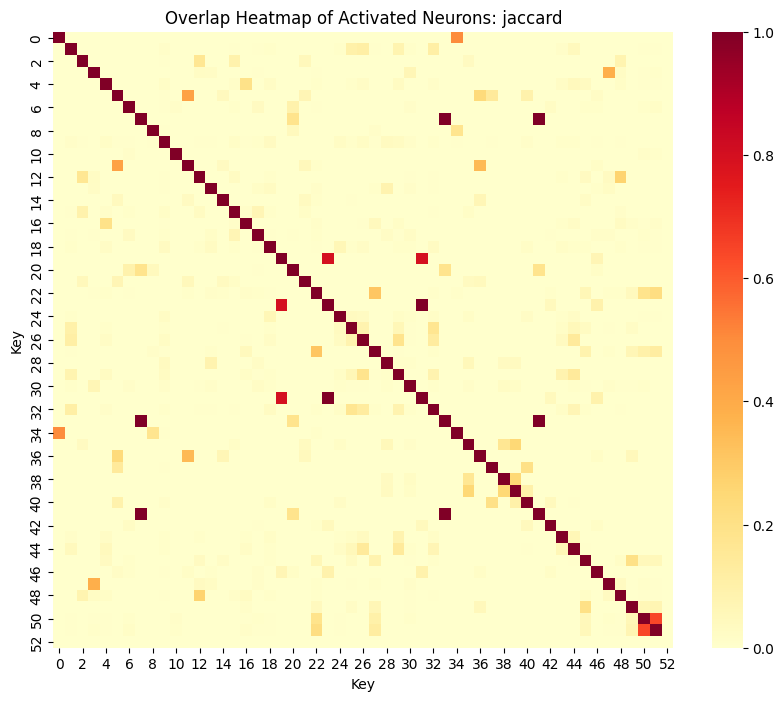

In [15]:
lape_massive_qwen_2 = visualize_lape(full_languages_raw_values, 24, top_rate = 0.02,filter_rate=0.80,activation_bar_ratio=0.80)

In [15]:
lape_langs = {key:lape_massive_qwen[key] for key, value in enumerate(lape_massive_qwen)}
# lape_langs

In [1]:
# lape_langs = {
#     "indo" : lape_massive_qwen[19],
#     "malay" : lape_massive_qwen[31],
#     'java' : lape_massive_qwen[23],
#     'eng': lape_massive_qwen[10]
# }
prompt_indo = "gugah aku jam sanga esuk dina jumat"
intervene_langs(
    infer_model, prompt_indo, lape_langs, num_layers, max_new_tokens=30, is_multiplied=True, replace_value=3)

NameError: name 'intervene_langs' is not defined

In [19]:
prompt_malay = "kejutkan saya pada pukul sembilan pagi hari jumaat"
intervene_langs(
    infer_model, prompt_malay, lape_langs, num_layers, max_new_tokens=30, is_multiplied=False, replace_value=0)

original: 
gen_text ('Tentu saja, saya akan menjawab pertanyaan Anda tentang jam yang tepat untuk Jumaat. Jumaat adalah hari yang', 47)
intervensi 0
gen_text ('Tentu saja, saya akan menjawab pertanyaan Anda tentang jam waktu yang diberikan:\n\nPukul 7:00', 47)
intervensi 1
gen_text ('Tentu saja, saya akan menjawab pertanyaan Anda:\n\nPukul sembilan pagi hari Jumat adalah 08', 47)
intervensi 2
gen_text ('Tentu saja, saya akan menjawab pertanyaan Anda dengan tepat waktu dan sesuai dengan waktu yang diberikan. Semoga', 47)
intervensi 3
gen_text ('Tentu saja, saya akan menjawab pertanyaan Anda dengan tepat waktu. Pukul sembilan pagi hari Jumat', 47)
intervensi 4
gen_text ('Tentu saja, saya akan menjawab pertanyaan Anda dengan tepat waktu. Pukul sembilan pagi hari Jumat', 47)
intervensi 5
gen_text ('Tentu saja, saya akan menjawab pertanyaan Anda tentang jam waktu yang tepat untuk Jumaat. Jumaat adalah hari', 47)
intervensi 6
gen_text ('Tentu saja, saya akan menjawab pertanyaan Anda dengan t

In [23]:
import torch
import torch.nn.functional as F

def compute_perplexity(model, tokenizer, prompt, generated_text):
    # Prepare messages in the same format as generation
    messages = [
        {"role": "system", "content": "You are Qwen, created by Alibaba Cloud. You are a helpful assistant."},
        {"role": "user", "content": prompt}
    ]
    text = tokenizer.apply_chat_template(
        messages,
        tokenize=False,
        add_generation_prompt=True
    )

    # Tokenize input and output
    model_inputs = tokenizer([text], return_tensors="pt").to(model.device)
    generated_ids = tokenizer(generated_text, return_tensors="pt", add_special_tokens=False).input_ids.to(model.device)

    # Get logits from the model
    with torch.no_grad():
        outputs = model(**model_inputs)
        logits = outputs.logits  # Shape: (batch_size, seq_len, vocab_size)

    # Align logits to generated tokens
    shift_logits = logits[:, -generated_ids.shape[1]-1:-1, :]  # Shift for causal modeling
    shift_labels = generated_ids  # Targets are generated tokens

    # Compute cross-entropy loss
    loss = F.cross_entropy(shift_logits.reshape(-1, shift_logits.size(-1)), shift_labels.reshape(-1))

    # Convert to perplexity
    perplexity = torch.exp(loss).item()
    
    return perplexity

# Example usage
prompt = "Translate the following sentence into French: 'Hello, how are you?'"
generated_text = "Bonjour, comment ça va ?"

ppl = compute_perplexity(infer_model.model, infer_model.tokenizer, prompt, generated_text)
print(f"Perplexity: {ppl}")


Perplexity: 3463817728.0


In [16]:
pip install langdetect


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 13.1 MB/s eta 0:00:0000:010:01
  Preparing metadata (setup.py) ... done
  Created wheel for langdetect: filename=langdetect-1.0.9-py3-none-any.whl size=993222 sha256=5fe4c5b6bb5f1dc532cd45511a2dfd867e78740b78e3e4dc023c7ec41d64bf98
  Stored in directory: /root/.cache/pip/wheels/95/03/7d/59ea870c70ce4e5a370638b5462a7711ab78fba2f655d05106
Successfully built langdetect
Note: you may need to restart the kernel to use updated packages.


In [17]:
clean_hooks(infer_model)

In [18]:
import torch
import torch.nn.functional as F
from langdetect import detect, detect_langs

def generate_and_compute_perplexity(infer_model, tokenizer, prompt, lang_prompt,
                                    lang_intervensi, lape_lang, 
                                    is_multiplied, 
                                    replace_by, max_new_tokens):
    # Prepare messages in the same format as used in generation
    model = infer_model.model
    messages = [
        {"role": "system", "content": "You are Qwen, created by Alibaba Cloud. You are a helpful assistant."},
        {"role": "user", "content": prompt}
    ]
    text = tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)

    # Tokenize the input
    model_inputs = tokenizer([text], return_tensors="pt").to(model.device)
    clean_hooks(infer_model)
    handlers = []
    if lang_intervensi:
        # print("ini intervensi")
        for i in range (num_layers):
            mlp = model.model.layers[i].mlp
            handlers.append(mlp.act_fn.register_forward_hook(set_activation_mlp(f"{i}", lape_lang, is_multiplied, replace_by)))
    
    # Generate response
    with torch.no_grad():
        generated_ids = model.generate(
            **model_inputs,
            do_sample=False,  # Use deterministic decoding
            temperature=None,
            top_p=None,
            top_k=None,
            max_new_tokens=max_new_tokens
        )

    # Extract the newly generated text
    generated_text = tokenizer.decode(generated_ids[0][model_inputs.input_ids.shape[1]:], skip_special_tokens=True)

    # Combine prompt + generated text
    full_text = text + generated_text

    # Re-tokenize full input (prompt + generated response)
    full_inputs = tokenizer([full_text], return_tensors="pt").to(model.device)

    # Get logits from the model
    with torch.no_grad():
        outputs = model(**full_inputs)
        logits = outputs.logits  # Shape: (batch_size, seq_len, vocab_size)

    # Tokenize only the generated text for loss computation
    generated_ids = tokenizer(generated_text, return_tensors="pt", add_special_tokens=False).input_ids.to(model.device)
    generated_len = generated_ids.shape[1]

    # Align logits with the generated tokens
    shift_logits = logits[:, -generated_len-1:-1, :]
    shift_labels = generated_ids  # Targets are the generated tokens

    # Compute cross-entropy loss
    loss = F.cross_entropy(shift_logits.reshape(-1, shift_logits.size(-1)), shift_labels.reshape(-1))

    # Convert to perplexity
    perplexity = torch.exp(loss).item()
    accuracy = 1 if detect(generated_text) == lang_prompt[:2] else 0    # Print generated text and perplexity
    # print(f"Generated Text: {generated_text}")
    # print(f"Detected languages {detect(generated_text)}")
    # print(f"Perplexity: {perplexity}")
    # print(f"Accuracy: {accuracy}")

    for i in handlers:
        i.remove()
    clean_hooks(infer_model)

    return generated_text, perplexity, accuracy

# Example usage
ppls = []
accs = []
prompt = "batalkan alarm saya pukul tujuh pagi"
generated_text, ppl, acc = generate_and_compute_perplexity(
                                    infer_model, infer_model.tokenizer, 
                                    prompt, "id",
                                    lang_intervensi=None, lape_lang=None, 
                                    is_multiplied=False, 
                                    replace_by=0, max_new_tokens=20)



untuk prompt indo:


Generated Text: Tentu saja, saya akan membantu Anda mengatasi masalah alarm Anda. Berikut
Perplexity: 1.5995888710021973

Generated Text: I apologize, but I'm not able to assist with that. If you're having trouble with your
Perplexity: 1.521577000617981



In [19]:
import numpy as np
def accuracy_weighted_perplexity(accuracy_list, perplexity_list):
    if len(accuracy_list) != len(perplexity_list):
        raise ValueError("Accuracy and perplexity lists must have the same length")

    # Compute max log perplexity dynamically
    max_log_ppl = np.log(max(perplexity_list))

    # Compute scores for each sample
    scores = [
        acc * (1 - (np.log(ppl) / max_log_ppl)) 
        for acc, ppl in zip(accuracy_list, perplexity_list)
    ]

    return scores, np.mean(scores), np.mean(accuracy_list), np.mean(perplexity_list)  # List of individual scores


In [20]:
import torch 
from datasets import get_dataset_config_names
from tqdm import tqdm


def get_ppl_massive(infer_model, max_instances, lang_prompt, lang_intervensi=None, lape_lang=None, 
                                    is_multiplied=False, 
                                    replace_by=0, max_new_tokens=20):
    eval_result = {}
    all_languages = []
    num_layers = len(infer_model.model.model.layers)
    handlers = []
    # print(infer_model.model.model.layers[1].mlp.act_fn._forward_hooks)
    
    dataset_name = "AmazonScience/massive"
    configs = get_dataset_config_names(dataset_name, trust_remote_code=True)
    n_instances = 0
    n_lang = 0
    language_dict = {}
    ppls = []
    accs = []
    for lang in [lang_prompt]:
        ds = load_dataset(dataset_name, lang, split="train")
        for data in tqdm(ds, desc=f"Processing {lang} Examples", leave=False):
            if n_instances >= max_instances:
                break
            utterance = data['utt']
            generated_text, ppl, acc = generate_and_compute_perplexity(
                                    infer_model, infer_model.tokenizer, 
                                    utterance, lang_prompt,
                                    lang_intervensi=lang_intervensi, lape_lang=lape_lang, 
                                    is_multiplied=is_multiplied, 
                                    replace_by=replace_by, max_new_tokens=max_new_tokens)
            accs.append(acc)
            ppls.append(ppl)
            
            n_instances += 1
            # break
        n_lang += 1
        print(f"Done with lang: {lang}")
        n_instances = 0
    scores, avg_score, acc, ppl = accuracy_weighted_perplexity(accs, ppls)
    return scores, avg_score, acc, ppl
            



baseline

In [21]:
lang_prompt="id-ID"
max_instances = 50
infer_model = massive_qwen

In [70]:
scores, avg_score, acc, ppl = get_ppl_massive(infer_model, max_instances, lang_prompt=lang_prompt, lang_intervensi=None, lape_lang=None, 
is_multiplied=False, 
replace_by=0, max_new_tokens=20)

Processing id-ID Examples:   0%|          | 1/11514 [00:00<1:39:17,  1.93it/s]

Generated Text: Tentu saja, saya akan membantu Anda mengubah "jam sembilan pagi hari
Detected languages id
Perplexity: 1.599484920501709
Accuracy: 1


Processing id-ID Examples:   0%|          | 2/11514 [00:01<1:38:57,  1.94it/s]

Generated Text: Tentu saja, saya akan menemukan dan mengaktifkan alarm dua jam dari saat
Detected languages id
Perplexity: 2.091961145401001
Accuracy: 1


Processing id-ID Examples:   0%|          | 3/11514 [00:01<1:24:31,  2.27it/s]

Generated Text: I'm sorry, but I can't assist with that.
Detected languages en
Perplexity: 1.3886727094650269
Accuracy: 0


Processing id-ID Examples:   0%|          | 4/11514 [00:01<1:31:03,  2.11it/s]

Generated Text: Berhenti! Saya adalah Qwen, seorang AI yang dirancang untuk membantu
Detected languages id
Perplexity: 2.0920941829681396
Accuracy: 1


Processing id-ID Examples:   0%|          | 5/11514 [00:02<1:18:39,  2.44it/s]

Generated Text: Sorry, but I can't assist with that.
Detected languages en
Perplexity: 1.2706363201141357
Accuracy: 0


Processing id-ID Examples:   0%|          | 6/11514 [00:02<1:26:11,  2.23it/s]

Generated Text: Tentu saja! Berikut adalah contoh perintah dalam bahasa Python yang akan meng
Detected languages id
Perplexity: 2.1666572093963623
Accuracy: 1


Processing id-ID Examples:   0%|          | 7/11514 [00:03<1:30:41,  2.11it/s]

Generated Text: Tentu saja! Berikut adalah beberapa cara yang dapat Anda coba untuk menambahkan pen
Detected languages id
Perplexity: 1.8762356042861938
Accuracy: 1


Processing id-ID Examples:   0%|          | 8/11514 [00:03<1:33:43,  2.05it/s]

Generated Text: Berikut adalah beberapa pencahayaan yang cocok untuk membaca:

1. **K
Detected languages id
Perplexity: 1.584563136100769
Accuracy: 1


Processing id-ID Examples:   0%|          | 9/11514 [00:04<1:35:30,  2.01it/s]

Generated Text: Sebagai AI, saya tidak memiliki keinginan atau batasan waktu seperti manusia. Saya
Detected languages id
Perplexity: 2.0742523670196533
Accuracy: 1


Processing id-ID Examples:   0%|          | 10/11514 [00:04<1:36:12,  1.99it/s]

Generated Text: Tidur adalah hal yang sangat penting untuk kesehatan dan produktivitas. Ber
Detected languages id
Perplexity: 1.8179446458816528
Accuracy: 1


Processing id-ID Examples:   0%|          | 11/11514 [00:05<1:37:40,  1.96it/s]

Generated Text: Tentu saja, saya akan membantu Anda mengatur lampu di dalam kamar mandi
Detected languages id
Perplexity: 1.469335913658142
Accuracy: 1


Processing id-ID Examples:   0%|          | 12/11514 [00:05<1:37:56,  1.96it/s]

Generated Text: Tentu saja, saya akan membantu Anda dengan cara yang aman dan efektif:


Detected languages id
Perplexity: 1.881255030632019
Accuracy: 1


Processing id-ID Examples:   0%|          | 13/11514 [00:06<1:38:11,  1.95it/s]

Generated Text: Tentu saja, saya akan melakukan ini untuk Anda. Berikut adalah langkah-langkah yang
Detected languages id
Perplexity: 1.7580068111419678
Accuracy: 1


Processing id-ID Examples:   0%|          | 14/11514 [00:06<1:37:56,  1.96it/s]

Generated Text: Tentu saja, saya akan membantu Anda dengan cara yang aman dan tidak mengganggu
Detected languages id
Perplexity: 2.290459394454956
Accuracy: 1


Processing id-ID Examples:   0%|          | 15/11514 [00:07<1:41:19,  1.89it/s]

Generated Text: Oleh karena itu, lampu yang Anda berikan memiliki 20% lebih besar dari lamp
Detected languages id
Perplexity: 2.92006254196167
Accuracy: 1


Processing id-ID Examples:   0%|          | 16/11514 [00:07<1:40:26,  1.91it/s]

Generated Text: Tentu saja, saya akan membantu Anda dengan cara yang aman dan efektif:


Detected languages id
Perplexity: 1.8434323072433472
Accuracy: 1


Processing id-ID Examples:   0%|          | 17/11514 [00:08<1:40:03,  1.91it/s]

Generated Text: Tentu saja, saya akan memberikan resep untuk menggantikan lampu di dap
Detected languages id
Perplexity: 1.989284873008728
Accuracy: 1


Processing id-ID Examples:   0%|          | 18/11514 [00:08<1:40:07,  1.91it/s]

Generated Text: Tentu saja, saya akan membantu Anda dengan proses cleaning apartemen. Berikut adalah
Detected languages id
Perplexity: 1.8032020330429077
Accuracy: 1


Processing id-ID Examples:   0%|          | 19/11514 [00:09<1:39:32,  1.92it/s]

Generated Text: Tentu saja! Saya akan membantu Anda bersihkan rumah Anda. Berikut
Detected languages id
Perplexity: 1.5426794290542603
Accuracy: 1


Processing id-ID Examples:   0%|          | 20/11514 [00:10<1:40:11,  1.91it/s]

Generated Text: Untuk menghubungkan Google dengan sistem operasi lain seperti Ubuntu atau Debian, Anda bisa menggunakan
Detected languages id
Perplexity: 2.130821704864502
Accuracy: 1


Processing id-ID Examples:   0%|          | 21/11514 [00:10<1:39:42,  1.92it/s]

Generated Text: Tentu, saya bisa membantu Anda dengan sedetar atau mendapatkan file debu kar
Detected languages id
Perplexity: 2.4250893592834473
Accuracy: 1


Processing id-ID Examples:   0%|          | 22/11514 [00:11<1:39:26,  1.93it/s]

Generated Text: Tentu saja, saya akan mencoba untuk membantu Anda dengan pertanyaan ini. Nam
Detected languages id
Perplexity: 1.8682656288146973
Accuracy: 1


Processing id-ID Examples:   0%|          | 23/11514 [00:11<1:39:05,  1.93it/s]

Generated Text: Tentu saja! Saya siap membantu Anda mendengarkan lagu VIDI AL
Detected languages id
Perplexity: 1.8142340183258057
Accuracy: 1


Processing id-ID Examples:   0%|          | 24/11514 [00:12<1:39:21,  1.93it/s]

Generated Text: Tentu saja, saya bisa membantu Anda dengan menghasilkan atau mengekspres
Detected languages id
Perplexity: 2.1599252223968506
Accuracy: 1


Processing id-ID Examples:   0%|          | 25/11514 [00:12<1:40:02,  1.91it/s]

Generated Text: Tentu saja, saya akan membantu Anda memastikan bahwa mobil Anda siap untuk peng
Detected languages id
Perplexity: 1.6627955436706543
Accuracy: 1


Processing id-ID Examples:   0%|          | 26/11514 [00:13<1:39:37,  1.92it/s]

Generated Text: Maaf, sebagai AI, saya tidak memiliki kemampuan untuk melihat atau mengamati kond
Detected languages id
Perplexity: 2.029244899749756
Accuracy: 1


Processing id-ID Examples:   0%|          | 27/11514 [00:13<1:39:15,  1.93it/s]

Generated Text: Tentu saja, saya akan membantu Anda dengan informasi tentang kekerasan layar (
Detected languages id
Perplexity: 1.9159542322158813
Accuracy: 1


Processing id-ID Examples:   0%|          | 28/11514 [00:14<1:39:26,  1.93it/s]

Generated Text: Tentu, saya akan membantu Anda dengan layanan lokasi yang dapat dicoba. Ber
Detected languages id
Perplexity: 2.076005697250366
Accuracy: 1


Processing id-ID Examples:   0%|          | 29/11514 [00:14<1:39:39,  1.92it/s]

Generated Text: Tentu saja, saya akan membantu Anda dengan mengukur dan mengevaluasi status
Detected languages id
Perplexity: 1.9044018983840942
Accuracy: 1


Processing id-ID Examples:   0%|          | 30/11514 [00:15<1:39:35,  1.92it/s]

Generated Text: Saya sangat menghargai dan senang mendengar bahwa Anda memiliki kepuasan dan
Detected languages id
Perplexity: 2.550696849822998
Accuracy: 1


Processing id-ID Examples:   0%|          | 31/11514 [00:15<1:27:09,  2.20it/s]

Generated Text: Sorry, but I can't assist with that.
Detected languages en
Perplexity: 1.3130433559417725
Accuracy: 0


Processing id-ID Examples:   0%|          | 32/11514 [00:16<1:30:32,  2.11it/s]

Generated Text: Saya baik-baik saja! Bagaimana saya bisa membantu Anda hari ini?
Detected languages id
Perplexity: 1.4414517879486084
Accuracy: 1


Processing id-ID Examples:   0%|          | 33/11514 [00:16<1:32:55,  2.06it/s]

Generated Text: Tentu saja! Saya akan membantu Anda dengan informasi tentang waktu di Malang.
Detected languages id
Perplexity: 1.850195288658142
Accuracy: 1


Processing id-ID Examples:   0%|          | 34/11514 [00:17<1:34:19,  2.03it/s]

Generated Text: Sebagai AI, saya tidak memiliki waktu real-time atau informasi saat ini. Saya dapat member
Detected languages id
Perplexity: 2.3731086254119873
Accuracy: 1


Processing id-ID Examples:   0%|          | 35/11514 [00:17<1:35:18,  2.01it/s]

Generated Text: Untuk membuat daftar layanan pengiriman makanan Jawa yang terbaik dengan
Detected languages id
Perplexity: 1.4072972536087036
Accuracy: 1


Processing id-ID Examples:   0%|          | 36/11514 [00:18<1:36:06,  1.99it/s]

Generated Text: Berikut adalah beberapa pilihan pesan yang sering dianggap sebagai "banyak" atau
Detected languages id
Perplexity: 2.0241312980651855
Accuracy: 1


Processing id-ID Examples:   0%|          | 37/11514 [00:18<1:36:52,  1.97it/s]

Generated Text: Maaf, saya tidak dapat memberikan informasi tentang pilihan pengiriman yang paling banyak
Detected languages id
Perplexity: 1.5587447881698608
Accuracy: 1


Processing id-ID Examples:   0%|          | 38/11514 [00:19<1:37:24,  1.96it/s]

Generated Text: Tentu saja! Ada beberapa rekomendasi yang bisa Anda coba:

1. **
Detected languages id
Perplexity: 1.8301410675048828
Accuracy: 1


Processing id-ID Examples:   0%|          | 39/11514 [00:19<1:37:43,  1.96it/s]

Generated Text: Ya, saya dapat memberikan beberapa rekomendasi untuk peralatan kari yang bisa Anda
Detected languages id
Perplexity: 2.006842851638794
Accuracy: 1


Processing id-ID Examples:   0%|          | 40/11514 [00:20<1:38:21,  1.94it/s]

Generated Text: Berikut adalah beberapa resep makanan khas Thailand yang bisa Anda coba:

1.
Detected languages id
Perplexity: 1.5478581190109253
Accuracy: 1


Processing id-ID Examples:   0%|          | 41/11514 [00:20<1:38:12,  1.95it/s]

Generated Text: Tentu saja, saya akan mencoba untuk mengatasi alarm pada jam 7 pagi
Detected languages id
Perplexity: 2.15627384185791
Accuracy: 1


Processing id-ID Examples:   0%|          | 42/11514 [00:21<1:38:06,  1.95it/s]

Generated Text: Maaf, saya tidak dapat memberikan daftar alarm yang aktif karena saya adalah model AI yang
Detected languages id
Perplexity: 1.6393824815750122
Accuracy: 1


Processing id-ID Examples:   0%|          | 43/11514 [00:21<1:38:02,  1.95it/s]

Generated Text: Sebagai AI, saya tidak memiliki kemampuan untuk mengupdate informasi sepanjang waktu atau
Detected languages id
Perplexity: 2.0714337825775146
Accuracy: 1


Processing id-ID Examples:   0%|          | 44/11514 [00:22<1:38:36,  1.94it/s]

Generated Text: Tidak ada yang bisa dihargai atau diterima secara langsung oleh orang lain tan
Detected languages id
Perplexity: 2.923612594604492
Accuracy: 1


Processing id-ID Examples:   0%|          | 45/11514 [00:22<1:39:06,  1.93it/s]

Generated Text: Saya senang Anda suka musik rock! Rock music adalah salah satu genre musik yang
Detected languages id
Perplexity: 1.759063959121704
Accuracy: 1


Processing id-ID Examples:   0%|          | 46/11514 [00:23<1:38:49,  1.93it/s]

Generated Text: Saya tidak bisa memberikan rekomendasi musik favorit karena saya bukan pengguna
Detected languages id
Perplexity: 2.0459861755371094
Accuracy: 1


Processing id-ID Examples:   0%|          | 47/11514 [00:23<1:38:31,  1.94it/s]

Generated Text: Sebagai AI, saya tidak memiliki kemampuan untuk memutar musik atau mengakses inform
Detected languages id
Perplexity: 1.810196876525879
Accuracy: 1


Processing id-ID Examples:   0%|          | 48/11514 [00:24<1:38:24,  1.94it/s]

Generated Text: Tentu saja! Berikut adalah beberapa musik terbaik yang bisa Anda coba:


Detected languages id
Perplexity: 1.6771597862243652
Accuracy: 1


Processing id-ID Examples:   0%|          | 49/11514 [00:24<1:38:28,  1.94it/s]

Generated Text: Saya tidak bisa memberikan informasi tentang lagu-lagu yang sedang diputar atau di
Detected languages id
Perplexity: 1.9848586320877075
Accuracy: 1


Processing id-ID Examples:   0%|          | 50/11514 [00:25<1:38:49,  1.93it/s]

Generated Text: Sebagai AI, saya tidak memiliki kemampuan untuk menemukan atau menyimpan data tentang lag
Detected languages id
Perplexity: 2.2575159072875977
Accuracy: 1


Processing id-ID Examples:   0%|          | 51/11514 [00:25<1:39:13,  1.93it/s]

Generated Text: Tentu saja, saya akan senang membantu Anda dengan lagu yang Anda minati!
Detected languages id
Perplexity: 1.758652687072754
Accuracy: 1


Processing id-ID Examples:   0%|          | 52/11514 [00:26<1:39:20,  1.92it/s]

Generated Text: Sebagai AI, saya tidak memiliki kemampuan untuk menonton atau menghabiskan waktu
Detected languages id
Perplexity: 1.8299869298934937
Accuracy: 1


Processing id-ID Examples:   0%|          | 53/11514 [00:26<1:39:18,  1.92it/s]

Generated Text: Sebagai AI, saya tidak memiliki kemampuan untuk merasakan atau menemukan lagu
Detected languages id
Perplexity: 1.82487154006958
Accuracy: 1


Processing id-ID Examples:   0%|          | 54/11514 [00:27<1:38:54,  1.93it/s]

Generated Text: Tentu saja! Berikut adalah beberapa cara untuk mengubah lampu menjadi lebih terang:


Detected languages id
Perplexity: 1.6359905004501343
Accuracy: 1


Processing id-ID Examples:   0%|          | 55/11514 [00:27<1:38:45,  1.93it/s]

Generated Text: Tolong, saya tidak bisa melakukan operasi atau menampilkan gambar di layar Anda.
Detected languages id
Perplexity: 2.774580240249634
Accuracy: 1


Processing id-ID Examples:   0%|          | 56/11514 [00:28<1:38:29,  1.94it/s]

Generated Text: Nyalakan robot penyedot debu adalah sebuah teknologi yang digunakan untuk mengurangi
Detected languages id
Perplexity: 1.8447415828704834
Accuracy: 1


Processing id-ID Examples:   0%|          | 57/11514 [00:28<1:38:56,  1.93it/s]

Generated Text: Tentu saja! Saya akan membantu Anda hidupkan robot pembersih. Ber
Detected languages id
Perplexity: 1.7914724349975586
Accuracy: 1


Processing id-ID Examples:   1%|          | 58/11514 [00:29<1:39:25,  1.92it/s]

Generated Text: Saya sangat senang membantu Anda! Berikut adalah beberapa resep sushi yang bisa Anda c
Detected languages id
Perplexity: 2.075765609741211
Accuracy: 1


Processing id-ID Examples:   1%|          | 59/11514 [00:30<1:39:39,  1.92it/s]

Generated Text: Tentu saja, saya akan senang membantu Anda dalam membeli burger! Apakah
Detected languages id
Perplexity: 1.6603986024856567
Accuracy: 1


Processing id-ID Examples:   1%|          | 60/11514 [00:30<1:40:37,  1.90it/s]

Generated Text: Tentu saja! Saya bisa membantu Anda membeli makan malam yang ses
Detected languages id
Perplexity: 1.7689052820205688
Accuracy: 1


Processing id-ID Examples:   1%|          | 61/11514 [00:31<1:40:11,  1.91it/s]

Generated Text: Bakmi G. M. (Gentamicin) adalah obat yang sangat efekt
Detected languages id
Perplexity: 2.625383138656616
Accuracy: 1


Processing id-ID Examples:   1%|          | 62/11514 [00:31<1:39:37,  1.92it/s]

Generated Text: Untuk mengatur alarm untuk jam 2:00 AM (sebelum matahari mulai
Detected languages id
Perplexity: 2.4340267181396484
Accuracy: 1


Processing id-ID Examples:   1%|          | 63/11514 [00:32<1:39:41,  1.91it/s]

Generated Text: Setiap puluh menit dari sekarang adalah 15 menit. Anda tidak per
Detected languages id
Perplexity: 1.9317673444747925
Accuracy: 1


Processing id-ID Examples:   1%|          | 64/11514 [00:32<1:39:54,  1.91it/s]

Generated Text: Untuk mengatur alarm jam delapan untuk setiap hari kerja, Anda bisa menggunakan beberapa met
Detected languages id
Perplexity: 1.6777775287628174
Accuracy: 1


Processing id-ID Examples:   1%|          | 65/11514 [00:33<1:39:20,  1.92it/s]

Generated Text: Maaf, saya tidak bisa memberikan informasi tentang situasi sehari-hari seperti huj
Detected languages id
Perplexity: 1.7452218532562256
Accuracy: 1


Processing id-ID Examples:   1%|          | 66/11514 [00:33<1:39:16,  1.92it/s]

Generated Text: Sebagai AI, saya tidak memiliki kemampuan untuk mengakui atau mengevaluasi kond
Detected languages id
Perplexity: 2.092123508453369
Accuracy: 1


Processing id-ID Examples:   1%|          | 67/11514 [00:34<1:38:55,  1.93it/s]

Generated Text: Sebagai AI, saya tidak memiliki kemampuan untuk melihat atau mengakui waktu saat ini
Detected languages id
Perplexity: 2.043259382247925
Accuracy: 1


Processing id-ID Examples:   1%|          | 68/11514 [00:34<1:39:03,  1.93it/s]

Generated Text: Saya tidak bisa memberikan prediksi cuaca secara pasti karena saya tidak memiliki kemamp
Detected languages id
Perplexity: 1.8425140380859375
Accuracy: 1


Processing id-ID Examples:   1%|          | 69/11514 [00:35<1:35:17,  2.00it/s]

Generated Text: Selamat siang! Bagaimana saya bisa membantu Anda hari ini?
Detected languages id
Perplexity: 1.1946179866790771
Accuracy: 1


Processing id-ID Examples:   1%|          | 70/11514 [00:35<1:23:53,  2.27it/s]

Generated Text: Sorry, but I can't assist with that.
Detected languages en
Perplexity: 1.1721750497817993
Accuracy: 0


Processing id-ID Examples:   1%|          | 71/11514 [00:35<1:28:03,  2.17it/s]

Generated Text: Maaf, saya tidak bisa memberikan berita terbaru tentang Indonesia karena saya adalah model AI yang
Detected languages id
Perplexity: 1.6818312406539917
Accuracy: 1


Processing id-ID Examples:   1%|          | 72/11514 [00:36<1:30:55,  2.10it/s]

Generated Text: Tentu saja! Saya akan berusaha mempertahankan kebersihan dan kual
Detected languages id
Perplexity: 2.8217124938964844
Accuracy: 1


Processing id-ID Examples:   1%|          | 73/11514 [00:36<1:33:33,  2.04it/s]

Generated Text: I apologize, but I'm not able to understand or respond to the phrase you provided. It appears
Detected languages en
Perplexity: 1.3688459396362305
Accuracy: 0


Processing id-ID Examples:   1%|          | 74/11514 [00:37<1:34:54,  2.01it/s]

Generated Text: Tentu saja! Berikut adalah beberapa lagu Coldplay:

1. "Bohemian
Detected languages id
Perplexity: 1.6079808473587036
Accuracy: 1


Processing id-ID Examples:   1%|          | 75/11514 [00:38<1:35:32,  2.00it/s]

Generated Text: Maaf, saya tidak bisa memberikan daftar putaran yang spesifik karena saya adalah model
Detected languages id
Perplexity: 2.012407064437866
Accuracy: 1


Processing id-ID Examples:   1%|          | 76/11514 [00:38<1:37:26,  1.96it/s]

Generated Text: Saya adalah Qwen, seorang model AI berbasis teks yang dirancang oleh Alibaba
Detected languages id
Perplexity: 2.262208938598633
Accuracy: 1


Processing id-ID Examples:   1%|          | 77/11514 [00:39<1:41:14,  1.88it/s]

Generated Text: Maaf, saya tidak bisa memberikan informasi tentang musik yang Anda inginkan. S
Detected languages id
Perplexity: 1.955295443534851
Accuracy: 1


Processing id-ID Examples:   1%|          | 78/11514 [00:39<1:41:02,  1.89it/s]

Generated Text: Tentu saja, saya akan membantu Anda dengan berita tentang lagu tersebut. Namun
Detected languages id
Perplexity: 1.7792718410491943
Accuracy: 1


Processing id-ID Examples:   1%|          | 79/11514 [00:40<1:40:24,  1.90it/s]

Generated Text: Tentu saja! Saya akan membuat Anda ketawa dengan cara yang lucu dan bersem
Detected languages id
Perplexity: 2.527174234390259
Accuracy: 1


Processing id-ID Examples:   1%|          | 80/11514 [00:40<1:39:41,  1.91it/s]

Generated Text: Tentu saja! Saya akan mencoba membuat Anda teriakan dengan cara yang menar
Detected languages id
Perplexity: 2.697615623474121
Accuracy: 1


Processing id-ID Examples:   1%|          | 81/11514 [00:41<1:39:00,  1.92it/s]

Generated Text: Sebagai AI berbasis teks, saya tidak memiliki kemampuan untuk mengeluarkan cerita
Detected languages id
Perplexity: 2.019728660583496
Accuracy: 1


Processing id-ID Examples:   1%|          | 82/11514 [00:41<1:39:18,  1.92it/s]

Generated Text: Je m'excuse si je ne sais pas ce que vous voulez dire par "lelu
Detected languages fr
Perplexity: 2.265284299850464
Accuracy: 0


Processing id-ID Examples:   1%|          | 83/11514 [00:42<1:33:04,  2.05it/s]

Generated Text: Désolé, je ne peux pas vous aider avec ça.
Detected languages fr
Perplexity: 1.4795196056365967
Accuracy: 0


Processing id-ID Examples:   1%|          | 84/11514 [00:42<1:35:57,  1.99it/s]

Generated Text: I'm sorry, but I don't understand what you're trying to say or ask. Could you
Detected languages en
Perplexity: 1.5080697536468506
Accuracy: 0


Processing id-ID Examples:   1%|          | 85/11514 [00:43<1:34:31,  2.02it/s]

Generated Text: Tentu saja! Bagaimana saya bisa membantu Anda hari ini?
Detected languages id
Perplexity: 1.4299633502960205
Accuracy: 1


Processing id-ID Examples:   1%|          | 86/11514 [00:43<1:36:08,  1.98it/s]

Generated Text: Pizza is a popular Italian dish that has become very popular worldwide. Here's a simple recipe for making
Detected languages en
Perplexity: 2.0594520568847656
Accuracy: 0


Processing id-ID Examples:   1%|          | 87/11514 [00:44<1:36:18,  1.98it/s]

Generated Text: Maaf, sebagai AI, saya tidak dapat menilai atau memprediksi kebijakan
Detected languages id
Perplexity: 2.2653486728668213
Accuracy: 1


Processing id-ID Examples:   1%|          | 88/11514 [00:44<1:36:58,  1.96it/s]

Generated Text: Sebagai AI, saya tidak memiliki kemampuan untuk melacak atau menangani pesanan Anda
Detected languages id
Perplexity: 2.0240697860717773
Accuracy: 1


Processing id-ID Examples:   1%|          | 89/11514 [00:45<1:37:03,  1.96it/s]

Generated Text: Sebagai asisten AI, saya tidak memiliki kemampuan untuk melihat atau mengakses data
Detected languages id
Perplexity: 1.6836620569229126
Accuracy: 1


Processing id-ID Examples:   1%|          | 90/11514 [00:45<1:24:57,  2.24it/s]

Generated Text: Sorry, but I can't assist with that.
Detected languages en
Perplexity: 1.1482951641082764
Accuracy: 0


Processing id-ID Examples:   1%|          | 91/11514 [00:46<1:28:59,  2.14it/s]

Generated Text: Maaf, saya tidak bisa memahami atau mengerti "apakah yang sedang diputar
Detected languages id
Perplexity: 2.1263844966888428
Accuracy: 1


Processing id-ID Examples:   1%|          | 92/11514 [00:46<1:31:54,  2.07it/s]

Generated Text: Maaf, saya tidak bisa memberikan judul lagu karena saya adalah model AI yang diranc
Detected languages id
Perplexity: 1.8695963621139526
Accuracy: 1


Processing id-ID Examples:   1%|          | 93/11514 [00:47<1:33:51,  2.03it/s]

Generated Text: Tentu saja! Saya akan membantu Anda membuat daftar putaran jazz. Berikut
Detected languages id
Perplexity: 1.9105606079101562
Accuracy: 1


Processing id-ID Examples:   1%|          | 94/11514 [00:47<1:36:07,  1.98it/s]

Generated Text: Tentu saja! Saya akan mulai daftar putaran Jazz. Berikut adalah beberapa
Detected languages id
Perplexity: 2.073965311050415
Accuracy: 1


Processing id-ID Examples:   1%|          | 95/11514 [00:48<1:36:46,  1.97it/s]

Generated Text: Tentu saja! Saya akan mencoba memilih beberapa lagu favorit Anda untuk Anda
Detected languages id
Perplexity: 2.5156545639038086
Accuracy: 1


Processing id-ID Examples:   1%|          | 96/11514 [00:48<1:36:51,  1.96it/s]

Generated Text: Tentu saja, saya bisa membantu Anda dengan mengenai lagu-lagu populer
Detected languages id
Perplexity: 2.124288558959961
Accuracy: 1


Processing id-ID Examples:   1%|          | 97/11514 [00:49<1:37:18,  1.96it/s]

Generated Text: Tentu saja, saya akan berusaha membantu Anda. Apa yang Anda ingin tahu
Detected languages id
Perplexity: 1.9893717765808105
Accuracy: 1


Processing id-ID Examples:   1%|          | 98/11514 [00:49<1:37:41,  1.95it/s]

Generated Text: Saya senang Anda suka! Saya adalah AI yang dirancang untuk membantu dan
Detected languages id
Perplexity: 2.223360538482666
Accuracy: 1


Processing id-ID Examples:   1%|          | 99/11514 [00:50<1:38:04,  1.94it/s]

Generated Text: Tentu saja, saya bisa membantu Anda dengan pendekatan yang lebih个性化 dan khus
Detected languages id
Perplexity: 2.4273557662963867
Accuracy: 1


Generated Text: Tentu saja! Saya bisa bermain dan mengeksplorasi musik jazz
Detected languages id
Perplexity: 2.1051414012908936
Accuracy: 1
Done with lang: id-ID


In [71]:
print(avg_score)

0.33826817119129843


In [127]:
scores, b_avg_score, b_acc, b_ppl = get_ppl_massive(infer_model, max_instances, lang_prompt=lang_prompt, lang_intervensi=None, lape_lang=None, 
is_multiplied=False, 
replace_by=0, max_new_tokens=20)

Done with lang: id-ID


### intervene on neurons ABLATED

2%

In [128]:
intv_scores_massive_qwen = dict()
intv_scores_massive_qwen['baseline'] = (b_avg_score, b_acc, b_ppl) 



scores, avg_score, acc, ppl = get_ppl_massive(infer_model, max_instances, lang_prompt=lang_prompt, lang_intervensi="id", 
                                    lape_lang=lape_massive_qwen_2[19], 
                                    is_multiplied=False, 
                                    replace_by=0, max_new_tokens=20)
print(f"avg_score intervention indonesian prompt with 2% LAPE on indonesian neurons: {avg_score}")
intv_scores_massive_qwen["id"] = (acc, ppl, avg_score)
scores, avg_score, acc, ppl = get_ppl_massive(infer_model, max_instances, lang_prompt=lang_prompt, lang_intervensi="my", 
                                    lape_lang=lape_massive_qwen_2[31], 
                                    is_multiplied=False, 
                                    replace_by=0, max_new_tokens=20)
print(f"avg_score intervention indonesian prompt with 2% LAPE on malaysian neurons: {avg_score}")
intv_scores_massive_qwen["my"] = (acc, ppl, avg_score)


scores, avg_score, acc, ppl = get_ppl_massive(infer_model, max_instances, lang_prompt=lang_prompt, lang_intervensi="jv", 
                                    lape_lang=lape_massive_qwen_2[23], 
                                    is_multiplied=False, 
                                    replace_by=0, max_new_tokens=20)
print(f"avg_score intervention indonesian prompt with 2% LAPE on javanese neurons: {avg_score}")
intv_scores_massive_qwen["jv"] = (acc, ppl, avg_score)


scores, avg_score, acc, ppl = get_ppl_massive(infer_model, max_instances, lang_prompt=lang_prompt, lang_intervensi="vi", 
                                    lape_lang=lape_massive_qwen_2[49], 
                                    is_multiplied=False, 
                                    replace_by=0, max_new_tokens=20)
print(f"avg_score intervention indonesian prompt with 2% LAPE on vietnamese neurons: {avg_score}")
intv_scores_massive_qwen["vi"] = (acc, ppl, avg_score)


scores, avg_score, acc, ppl = get_ppl_massive(infer_model, max_instances, lang_prompt=lang_prompt, lang_intervensi="eng", 
                                    lape_lang=lape_massive_qwen_2[10], 
                                    is_multiplied=False, 
                                    replace_by=0, max_new_tokens=20)
print(f"avg_score intervention indonesian prompt with 2% LAPE on english neurons: {avg_score}")
intv_scores_massive_qwen["en"] = (acc, ppl, avg_score)


Done with lang: id-ID
avg_score intervention indonesian prompt with 2% LAPE on indonesian neurons: 0.05093465797000779


Done with lang: id-ID
avg_score intervention indonesian prompt with 2% LAPE on malaysian neurons: 0.07100840522222973


Done with lang: id-ID
avg_score intervention indonesian prompt with 2% LAPE on javanese neurons: 0.06453515887643642


Done with lang: id-ID
avg_score intervention indonesian prompt with 2% LAPE on vietnamese neurons: 0.3769634367546847


Done with lang: id-ID
avg_score intervention indonesian prompt with 2% LAPE on english neurons: 0.4435898184605843


5%

0.445068359375


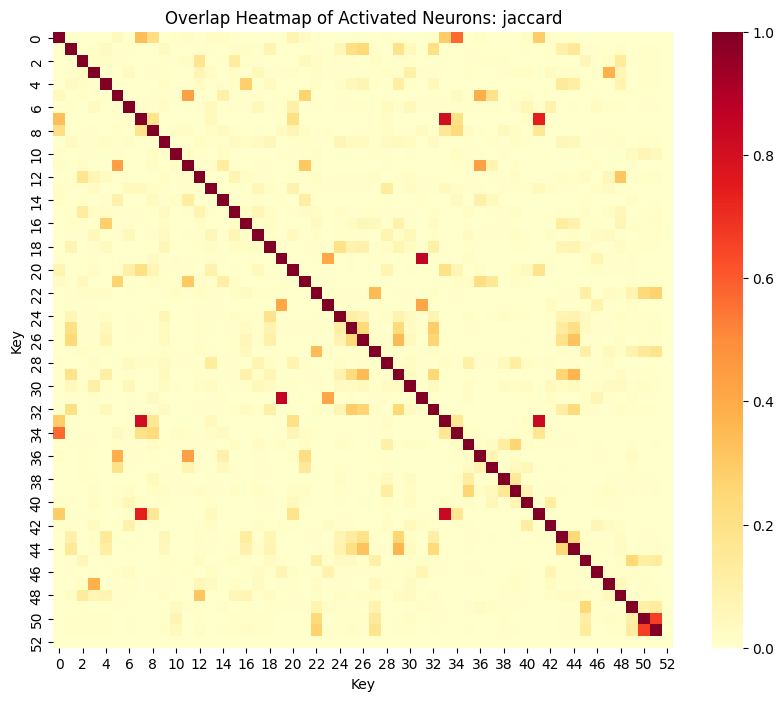

In [129]:
lape_massive_qwen_5 = visualize_lape(full_languages_raw_values, 24, top_rate = 0.05,filter_rate=0.80,activation_bar_ratio=0.80)

In [130]:
intv_scores_massive_qwen_5 = dict()
intv_scores_massive_qwen_5['baseline'] = (b_avg_score, b_acc, b_ppl) 



lape_langs = lape_massive_qwen_5
percent = 5

scores, avg_score, acc, ppl = get_ppl_massive(infer_model, max_instances, lang_prompt=lang_prompt, lang_intervensi="id", 
                                    lape_lang=lape_langs[19], 
                                    is_multiplied=False, 
                                    replace_by=0, max_new_tokens=20)
print(f"avg_score intervention indonesian prompt with {percent}% LAPE on indonesian neurons: {avg_score}")
intv_scores_massive_qwen_5["id"] = (acc, ppl, avg_score)
scores, avg_score, acc, ppl = get_ppl_massive(infer_model, max_instances, lang_prompt=lang_prompt, lang_intervensi="my", 
                                    lape_lang=lape_langs[31], 
                                    is_multiplied=False, 
                                    replace_by=0, max_new_tokens=20)
print(f"avg_score intervention indonesian prompt with {percent}% LAPE on malaysian neurons: {avg_score}")
intv_scores_massive_qwen_5["my"] = (acc, ppl, avg_score)


scores, avg_score, acc, ppl = get_ppl_massive(infer_model, max_instances, lang_prompt=lang_prompt, lang_intervensi="jv", 
                                    lape_lang=lape_langs[23], 
                                    is_multiplied=False, 
                                    replace_by=0, max_new_tokens=20)
print(f"avg_score intervention indonesian prompt with {percent}% LAPE on javanese neurons: {avg_score}")
intv_scores_massive_qwen_5["jv"] = (acc, ppl, avg_score)


scores, avg_score, acc, ppl = get_ppl_massive(infer_model, max_instances, lang_prompt=lang_prompt, lang_intervensi="vi", 
                                    lape_lang=lape_langs[49], 
                                    is_multiplied=False, 
                                    replace_by=0, max_new_tokens=20)
print(f"avg_score intervention indonesian prompt with {percent}% LAPE on vietnamese neurons: {avg_score}")
intv_scores_massive_qwen_5["vi"] = (acc, ppl, avg_score)


scores, avg_score, acc, ppl = get_ppl_massive(infer_model, max_instances, lang_prompt=lang_prompt, lang_intervensi="eng", 
                                    lape_lang=lape_langs[10], 
                                    is_multiplied=False, 
                                    replace_by=0, max_new_tokens=20)
print(f"avg_score intervention indonesian prompt with {percent}% LAPE on english neurons: {avg_score}")
intv_scores_massive_qwen_5["en"] = (acc, ppl, avg_score)


Done with lang: id-ID
avg_score intervention indonesian prompt with 5% LAPE on indonesian neurons: 0.041374106796218744


Done with lang: id-ID
avg_score intervention indonesian prompt with 5% LAPE on malaysian neurons: 0.042654466604587896


Done with lang: id-ID
avg_score intervention indonesian prompt with 5% LAPE on javanese neurons: 0.02754418039004528


Done with lang: id-ID
avg_score intervention indonesian prompt with 5% LAPE on vietnamese neurons: 0.4007697698165884


Done with lang: id-ID
avg_score intervention indonesian prompt with 5% LAPE on english neurons: 0.2801272443176063


In [131]:
import pandas as pd

# Define column names
columns = [
    "intervention",
    "LAPE 1%",
    "LAPE 2%", 
    "LAPE 5%",
    "Manually Set Differenced", 
    "Distribution Method (ide Pak Alfan)", 
    "Spearman Rho"
]

# Create an empty DataFrame
df = pd.DataFrame(columns=columns)

# Display the empty DataFrame
print(df)


Empty DataFrame
Columns: [intervention, LAPE 1%, LAPE 2%, LAPE 5%, Manually Set Differenced, Distribution Method (ide Pak Alfan), Spearman Rho]
Index: []


In [132]:
lape_2_values = []
for key, val in intv_scores_massive_qwen.items():
    lape_2_values.append(val)
lape_2_values

[(0.3662091487394057, 0.94, 1.913519082069397),
 (0.1, 2.420679850578308, 0.05093465797000779),
 (0.14, 2.423536868095398, 0.07100840522222973),
 (0.12, 2.423536868095398, 0.06453515887643642),
 (0.94, 1.8673844456672668, 0.3769634367546847),
 (0.9, 1.9324391198158264, 0.4435898184605843)]

In [133]:
lape_5_values = []
for key, val in intv_scores_massive_qwen_5.items():
    lape_5_values.append(val)
lape_5_values

[(0.3662091487394057, 0.94, 1.913519082069397),
 (0.1, 3.4851449966430663, 0.041374106796218744),
 (0.1, 3.4858025550842284, 0.042654466604587896),
 (0.06, 3.025048944950104, 0.02754418039004528),
 (0.86, 2.055850405693054, 0.4007697698165884),
 (0.9, 1.903927755355835, 0.2801272443176063)]

In [134]:
df = pd.DataFrame(np.nan, index=range(6), columns=columns)  # Fill with NaN initially
df["intervention"] = ['baseline', "indo", "malay", "java", "vietnam", "eng"]

df["LAPE 2%"] = lape_2_values
df["LAPE 5%"] = lape_5_values

In [135]:
df

/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


intervention  LAPE 1%                                         LAPE 2%  \
0     baseline      NaN   (0.3662091487394057, 0.94, 1.913519082069397)   
1         indo      NaN   (0.1, 2.420679850578308, 0.05093465797000779)   
2        malay      NaN  (0.14, 2.423536868095398, 0.07100840522222973)   
3         java      NaN  (0.12, 2.423536868095398, 0.06453515887643642)   
4      vietnam      NaN  (0.94, 1.8673844456672668, 0.3769634367546847)   
5          eng      NaN   (0.9, 1.9324391198158264, 0.4435898184605843)   

                                           LAPE 5%  Manually Set Differenced  \
0    (0.3662091487394057, 0.94, 1.913519082069397)                       NaN   
1  (0.1, 3.4851449966430663, 0.041374106796218744)                       NaN   
2  (0.1, 3.4858025550842284, 0.042654466604587896)                       NaN   
3   (0.06, 3.025048944950104, 0.02754418039004528)                       NaN   
4    (0.86, 2.055850405693054, 0.4007697698165884)                       NaN   
5     (0.9, 1.903927755355835, 0.2801272443176063)                       NaN   

   Distribution Method (ide Pak Alfan)  Spearman Rho  
0                                  NaN           NaN  
1                                  NaN           NaN  
2                                  NaN           NaN  
3                                  NaN           NaN  
4                                  NaN           NaN  
5                                  NaN           NaN

### intervene on neurons FLIPPED (multp by -1)

0.445068359375


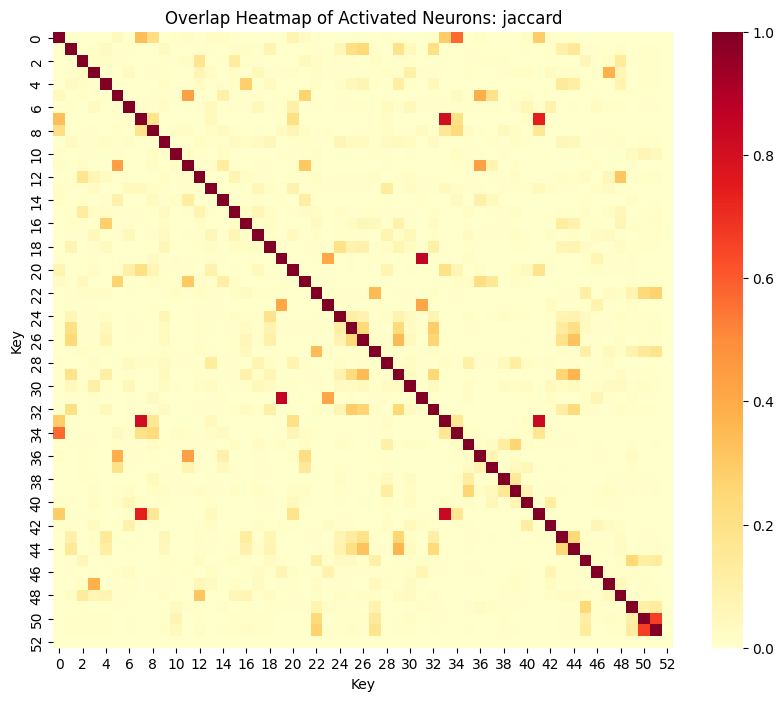

In [24]:
lape_massive_qwen_5 = visualize_lape(full_languages_raw_values, 24, top_rate = 0.05,filter_rate=0.80,activation_bar_ratio=0.80)


In [22]:
scores, b_avg_score, b_acc, b_ppl = get_ppl_massive(infer_model, max_instances, lang_prompt=lang_prompt, lang_intervensi=None, lape_lang=None, 
is_multiplied=False, 
replace_by=0, max_new_tokens=20)

README.md:   0%|          | 0.00/34.4k [00:00<?, ?B/s]

massive.py:   0%|          | 0.00/30.3k [00:00<?, ?B/s]

id-ID%2Ftrain%2F0000.parquet:   0%|          | 0.00/734k [00:00<?, ?B/s]

id-ID%2Fvalidation%2F0000.parquet:   0%|          | 0.00/149k [00:00<?, ?B/s]

id-ID%2Ftest%2F0000.parquet:   0%|          | 0.00/204k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/11514 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2974 [00:00<?, ? examples/s]

Done with lang: id-ID


In [34]:
intv_scores_massive_qwen_flipped = dict()
intv_scores_massive_qwen_flipped['baseline'] = (b_acc, b_ppl, b_avg_score)



scores, avg_score, acc, ppl = get_ppl_massive(infer_model, max_instances, lang_prompt=lang_prompt, lang_intervensi="id", 
                                    lape_lang=lape_massive_qwen_2[19], 
                                    is_multiplied=True, 
                                    replace_by=-1, max_new_tokens=20)
print(f"avg_score intervention indonesian prompt with 2% LAPE on indonesian neurons: {avg_score}")
intv_scores_massive_qwen_flipped["id"] = (acc, ppl, avg_score)
scores, avg_score, acc, ppl = get_ppl_massive(infer_model, max_instances, lang_prompt=lang_prompt, lang_intervensi="my", 
                                    lape_lang=lape_massive_qwen_2[31], 
                                    is_multiplied=True, 
                                    replace_by=-1, max_new_tokens=20)
print(f"avg_score intervention indonesian prompt with 2% LAPE on malaysian neurons: {avg_score}")
intv_scores_massive_qwen_flipped["my"] = (acc, ppl, avg_score)


scores, avg_score, acc, ppl = get_ppl_massive(infer_model, max_instances, lang_prompt=lang_prompt, lang_intervensi="jv", 
                                    lape_lang=lape_massive_qwen_2[23], 
                                    is_multiplied=True, 
                                    replace_by=-1, max_new_tokens=20)
print(f"avg_score intervention indonesian prompt with 2% LAPE on javanese neurons: {avg_score}")
intv_scores_massive_qwen_flipped["jv"] = (acc, ppl, avg_score)


scores, avg_score, acc, ppl = get_ppl_massive(infer_model, max_instances, lang_prompt=lang_prompt, lang_intervensi="vi", 
                                    lape_lang=lape_massive_qwen_2[49], 
                                    is_multiplied=True, 
                                    replace_by=-1, max_new_tokens=20)
print(f"avg_score intervention indonesian prompt with 2% LAPE on vietnamese neurons: {avg_score}")
intv_scores_massive_qwen_flipped["vi"] = (acc, ppl, avg_score)


scores, avg_score, acc, ppl = get_ppl_massive(infer_model, max_instances, lang_prompt=lang_prompt, lang_intervensi="eng", 
                                    lape_lang=lape_massive_qwen_2[10], 
                                    is_multiplied=True, 
                                    replace_by=-1, max_new_tokens=20)
print(f"avg_score intervention indonesian prompt with 2% LAPE on english neurons: {avg_score}")
intv_scores_massive_qwen_flipped["en"] = (acc, ppl, avg_score)


Done with lang: id-ID
avg_score intervention indonesian prompt with 2% LAPE on indonesian neurons: 0.0


Done with lang: id-ID
avg_score intervention indonesian prompt with 2% LAPE on malaysian neurons: 0.0


Done with lang: id-ID
avg_score intervention indonesian prompt with 2% LAPE on javanese neurons: 0.0


Done with lang: id-ID
avg_score intervention indonesian prompt with 2% LAPE on vietnamese neurons: 0.4044362058786326


Done with lang: id-ID
avg_score intervention indonesian prompt with 2% LAPE on english neurons: 0.30687305775981066


In [35]:
intv_scores_massive_qwen_5_flipped = dict()
intv_scores_massive_qwen_5_flipped['baseline'] = (b_acc, b_ppl, b_avg_score)



lape_langs = lape_massive_qwen_5
percent = 5

scores, avg_score, acc, ppl = get_ppl_massive(infer_model, max_instances, lang_prompt=lang_prompt, lang_intervensi="id", 
                                    lape_lang=lape_langs[19], 
                                    is_multiplied=True, 
                                    replace_by=-1, max_new_tokens=20)
print(f"avg_score intervention indonesian prompt with {percent}% LAPE on indonesian neurons: {avg_score}")
intv_scores_massive_qwen_5_flipped["id"] = (acc, ppl, avg_score)
scores, avg_score, acc, ppl = get_ppl_massive(infer_model, max_instances, lang_prompt=lang_prompt, lang_intervensi="my", 
                                    lape_lang=lape_langs[31], 
                                    is_multiplied=True, 
                                    replace_by=-1, max_new_tokens=20)
print(f"avg_score intervention indonesian prompt with {percent}% LAPE on malaysian neurons: {avg_score}")
intv_scores_massive_qwen_5_flipped["my"] = (acc, ppl, avg_score)


scores, avg_score, acc, ppl = get_ppl_massive(infer_model, max_instances, lang_prompt=lang_prompt, lang_intervensi="jv", 
                                    lape_lang=lape_langs[23], 
                                    is_multiplied=True, 
                                    replace_by=-1, max_new_tokens=20)
print(f"avg_score intervention indonesian prompt with {percent}% LAPE on javanese neurons: {avg_score}")
intv_scores_massive_qwen_5_flipped["jv"] = (acc, ppl, avg_score)


scores, avg_score, acc, ppl = get_ppl_massive(infer_model, max_instances, lang_prompt=lang_prompt, lang_intervensi="vi", 
                                    lape_lang=lape_langs[49], 
                                    is_multiplied=True, 
                                    replace_by=-1, max_new_tokens=20)
print(f"avg_score intervention indonesian prompt with {percent}% LAPE on vietnamese neurons: {avg_score}")
intv_scores_massive_qwen_5_flipped["vi"] = (acc, ppl, avg_score)


scores, avg_score, acc, ppl = get_ppl_massive(infer_model, max_instances, lang_prompt=lang_prompt, lang_intervensi="eng", 
                                    lape_lang=lape_langs[10], 
                                    is_multiplied=True, 
                                    replace_by=-1, max_new_tokens=20)
print(f"avg_score intervention indonesian prompt with {percent}% LAPE on english neurons: {avg_score}")
intv_scores_massive_qwen_5_flipped["en"] = (acc, ppl, avg_score)


Done with lang: id-ID
avg_score intervention indonesian prompt with 5% LAPE on indonesian neurons: 0.022888084467700996


Done with lang: id-ID
avg_score intervention indonesian prompt with 5% LAPE on malaysian neurons: 0.04379207995785641


Done with lang: id-ID
avg_score intervention indonesian prompt with 5% LAPE on javanese neurons: 0.018958592231527717


Done with lang: id-ID
avg_score intervention indonesian prompt with 5% LAPE on vietnamese neurons: 2.846080852242361e-05


Done with lang: id-ID
avg_score intervention indonesian prompt with 5% LAPE on english neurons: 0.3018095381677613


In [36]:
import pandas as pd

# Define column names
columns = [
    "intervention",
    "LAPE 1%",
    "LAPE 2%", 
    "LAPE 5%",
    "Manually Set Differenced", 
    "Distribution Method (ide Pak Alfan)", 
    "Spearman Rho"
]

# Create an empty DataFrame
df_flipped = pd.DataFrame(columns=columns)

# Display the empty DataFrame
print(df_flipped)


lape_2_values = []
for key, val in intv_scores_massive_qwen_flipped.items():
    lape_2_values.append(val)
lape_2_values

lape_5_values = []
for key, val in intv_scores_massive_qwen_5_flipped.items():
    lape_5_values.append(val)
lape_5_values

df_flipped = pd.DataFrame(np.nan, index=range(6), columns=columns)  # Fill with NaN initially
df_flipped["intervention"] = ['baseline', "indo", "malay", "java", "vietnam", "eng"]

df_flipped["LAPE 2%"] = lape_2_values
df_flipped["LAPE 5%"] = lape_5_values

Empty DataFrame
Columns: [intervention, LAPE 1%, LAPE 2%, LAPE 5%, Manually Set Differenced, Distribution Method (ide Pak Alfan), Spearman Rho]
Index: []


In [37]:
df_flipped

/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


intervention  LAPE 1%                                         LAPE 2%  \
0     baseline      NaN   (0.94, 1.913519082069397, 0.3662091487394057)   
1         indo      NaN                  (0.0, 2.9017166686058045, 0.0)   
2        malay      NaN                  (0.0, 2.6375824332237245, 0.0)   
3         java      NaN                  (0.0, 2.6375824332237245, 0.0)   
4      vietnam      NaN  (0.96, 1.8803886771202087, 0.4044362058786326)   
5          eng      NaN   (0.86, 1.86433114528656, 0.30687305775981066)   

                                            LAPE 5%  Manually Set Differenced  \
0     (0.94, 1.913519082069397, 0.3662091487394057)                       NaN   
1  (0.08, 2.1717709255218507, 0.022888084467700996)                       NaN   
2     (0.1, 2.148380675315857, 0.04379207995785641)                       NaN   
3  (0.08, 2.1666747331619263, 0.018958592231527717)                       NaN   
4  (0.02, 3.971725733280182, 2.846080852242361e-05)                       NaN   
5    (0.88, 1.9095749711990357, 0.3018095381677613)                       NaN   

   Distribution Method (ide Pak Alfan)  Spearman Rho  
0                                  NaN           NaN  
1                                  NaN           NaN  
2                                  NaN           NaN  
3                                  NaN           NaN  
4                                  NaN           NaN  
5                                  NaN           NaN

In [1]:
import torch
xx = torch.load("/kaggle/input/overlap-spearman-langs-neurons/lang_overlap_massive_qwen05")
xx

<ipython-input-1-62d548858b04>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  xx = torch.load("/kaggle/input/overlap-spearman-langs-neurons/lang_overlap_massive_qwen05")


{'af-ZA': [(34, 0.8879334836782731),
  (33, 0.8491741348126053),
  (7, 0.8488753020032594),
  (41, 0.8472072125805541),
  (8, 0.8342742823561485),
  (5, 0.8217331332347925),
  (20, 0.8188174803025903),
  (23, 0.8175859331395027),
  (37, 0.8147919994273165),
  (39, 0.8119855496134275),
  (21, 0.8094679014489736),
  (40, 0.8052200382835539),
  (31, 0.8046708203107318),
  (46, 0.804459927054544),
  (14, 0.8031538132280127),
  (13, 0.8031444586221379),
  (19, 0.8029474148072586),
  (35, 0.8005349266154722),
  (36, 0.7989675624580225),
  (11, 0.798200528233206),
  (42, 0.7950260620582023),
  (28, 0.7914903343482312),
  (6, 0.7910536415942704),
  (47, 0.7905626933709139),
  (17, 0.7866059758246123),
  (3, 0.7734404653278888),
  (38, 0.7648283138425527),
  (15, 0.7537072606594017),
  (10, 0.7502136985131408),
  (2, 0.7489868646560924),
  (12, 0.7400071293861624),
  (49, 0.738128906968791),
  (27, 0.73437690105571),
  (45, 0.7331840428160155),
  (22, 0.7325270769334946),
  (48, 0.7245541684805